In [1]:
import pandas as pd
from torch.utils.data import DataLoader,Dataset, Subset
import numpy as np
import tft_model
from data_formatters import ts_dataset  
import data_formatters.base
import expt_settings.configs
import importlib
from data_formatters import utils
import torch.optim as optim
import torch
from tqdm import tqdm
import pickle
import time

In [2]:
importlib.reload(utils)

<module 'data_formatters.utils' from '/home/arda/Desktop/thesis/submodules/Temporal_Fusion_Transform/data_formatters/utils.py'>

In [3]:
ExperimentConfig = expt_settings.configs.ExperimentConfig

config = ExperimentConfig('m4', 'outputs')

with open('data_formatter_m4.pkl', 'rb') as input:
    data_formatter = pickle.load(input)

# Sets up default params
fixed_params = data_formatter.get_experiment_params()
params = data_formatter.get_default_model_params()

fixed_params.update(params)
fixed_params['batch_first'] = True
fixed_params['name'] = 'test'
fixed_params['device'] = 'cpu'# torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fixed_params['minibatch_size'] = 256
fixed_params['category_count'] = [6]
device = fixed_params['device']


In [4]:
test_data = pd.read_csv('data/m4_test.csv', index_col=0)
test_transformed_data = data_formatter.transform_inputs(test_data)

/home/arda/anaconda3/envs/thesis/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [7]:
importlib.reload(tft_model)
model = tft_model.TFT(fixed_params).to(device)
model.load_state_dict(torch.load('m4_best_model.pth'))
model.eval()

{'total_time_steps': 54, 'num_encoder_steps': 36, 'num_epochs': 100, 'early_stopping_patience': 5, 'multiprocessing_workers': 5, 'column_definition': [('id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('time', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('value', <DataTypes.REAL_VALUED: 0>, <InputTypes.TARGET: 0>), ('time_cat', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('category', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>)], 'input_size': 3, 'output_size': 1, 'category_counts': [6], 'input_obs_loc': [0], 'static_input_loc': [2], 'known_regular_inputs': [1], 'known_categorical_inputs': [0], 'dropout_rate': 0.1, 'hidden_layer_size': 160, 'learning_rate': 0.001, 'minibatch_size': 256, 'max_gradient_norm': 0.01, 'num_heads': 4, 'stack_size': 1, 'batch_first': True, 'name': 'test', 'device': 'cpu', 'category_count': [6]}
num_categorical_variables
1


TFT(
  (embeddings): ModuleList(
    (0): Embedding(6, 160)
  )
  (static_input_layer): Linear(in_features=160, out_features=160, bias=True)
  (time_varying_embedding_layer): LinearLayer(
    (layer): TimeDistributed(
      (module): Linear(in_features=1, out_features=160, bias=True)
    )
  )
  (static_combine_and_mask): StaticCombineAndMask(
    (flattened_grn): GatedResidualNetwork(
      (linear_layer): LinearLayer(
        (layer): Linear(in_features=160, out_features=1, bias=True)
      )
      (hidden_linear_layer1): LinearLayer(
        (layer): Linear(in_features=160, out_features=160, bias=True)
      )
      (hidden_context_layer): LinearLayer(
        (layer): Linear(in_features=160, out_features=160, bias=True)
      )
      (hidden_linear_layer2): LinearLayer(
        (layer): Linear(in_features=160, out_features=160, bias=True)
      )
      (elu1): ELU(alpha=1.0)
      (glu): GLU(
        (dropout): Dropout(p=0.1, inplace=False)
        (activation_layer): LinearLayer(


In [8]:
test_ds = ts_dataset.TSDataset(fixed_params, 48000, test_transformed_data)

Getting valid sampling locations.
# available segments=48000
Max samples=48000 exceeds # available segments=48000
1000 of 48000 samples done...
2000 of 48000 samples done...
3000 of 48000 samples done...
4000 of 48000 samples done...
5000 of 48000 samples done...
6000 of 48000 samples done...
7000 of 48000 samples done...
8000 of 48000 samples done...
9000 of 48000 samples done...
10000 of 48000 samples done...
11000 of 48000 samples done...
12000 of 48000 samples done...
13000 of 48000 samples done...
14000 of 48000 samples done...
15000 of 48000 samples done...
16000 of 48000 samples done...
17000 of 48000 samples done...
18000 of 48000 samples done...
19000 of 48000 samples done...
20000 of 48000 samples done...
21000 of 48000 samples done...
22000 of 48000 samples done...
23000 of 48000 samples done...
24000 of 48000 samples done...
25000 of 48000 samples done...
26000 of 48000 samples done...
27000 of 48000 samples done...
28000 of 48000 samples done...
29000 of 48000 samples done

In [9]:
test_loader = DataLoader(
            test_ds,
            batch_size=fixed_params['minibatch_size'],
            num_workers=2,
            shuffle=False
        )

In [10]:
final_forecasts = []
truth = []
dfs = []
for idx, batch in enumerate(test_loader):
    with torch.no_grad():
        output, all_inputs, attention_components = model(batch['inputs'])
        flat_prediction = pd.DataFrame(
          output.detach().cpu().numpy()[:, :, 1],
          columns=[
              't+{}'.format(i)
              for i in range(18)
          ])
        cols = list(flat_prediction.columns)
#         flat_prediction['forecast_time'] = batch['time'][:, 54 - 1, 0]
        flat_prediction['identifier'] = batch['identifier'][0][0].detach().cpu().numpy()
        dfs.append(flat_prediction)
#         df = pd.DataFrame({
#             'id': batch['identifier'][0][0].detach().cpu().numpy(),
#             'time': batch['time'][0][0].detach().cpu().numpy(),
# #             'output': output[:,:,1].detach().cpu().numpy(),
#             'category': batch['inputs'][:,:18,2].detach().cpu().numpy(),
#             'time_cat': batch['inputs'][:,:18,1].detach().cpu().numpy(),
            
#         })
#         print(batch['time'])
#         print(batch['identifier'])
#         dfs.append(df)
#         a = output[:,:,1].detach().cpu().numpy()
#         final_forecasts.append(a)
#         truth.append(batch['outputs'])
#     break

In [22]:
all_predictions = pd.concat(dfs)

In [23]:
all_predictions_unnormalized = data_formatter.format_predictions(all_predictions)

In [24]:
all_predictions_unnormalized

,t+0,t+1,t+2,t+3,t+4,t+5,t+6,t+7,t+8,t+9,t+10,t+11,t+12,t+13,t+14,t+15,t+16,t+17,identifier
0,8063.508789,7104.067871,6030.321777,5992.728516,5604.426758,5418.181152,5526.663086,5250.806641,5165.821289,4997.172363,5150.249512,6497.036133,7580.217773,6948.403809,6177.092773,6301.488281,5945.148926,5785.756836,1
1,2519.071045,2040.673096,2041.571045,1880.919556,1825.895264,1832.087402,1980.114502,1954.800293,1932.448730,1810.577148,1860.679443,2475.611572,2603.227539,2180.435303,2201.615967,2007.540527,1897.187866,1877.701294,2
2,13108.545898,13120.634766,13177.564453,13227.753906,13268.650391,13283.268555,13267.883789,13233.587891,13189.882812,13143.978516,13104.396484,13078.715820,13068.772461,13072.294922,13081.875977,13081.304688,13059.160156,13031.944336,3
3,6584.670410,6574.578125,6566.540039,6563.057617,6560.179688,6557.083984,6555.025391,6554.160645,6554.003906,6554.509766,6555.809082,6557.825195,6560.390137,6563.455078,6567.062988,6571.225098,6575.915039,6581.044922,4
4,4351.281738,4362.601074,4372.187500,4379.628906,4382.774414,4382.413086,4381.326172,4381.081543,4382.101562,4384.914551,4390.341797,4398.632324,4408.666016,4418.626465,4427.214355,4433.960449,4438.873047,4442.321289,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,4512.383301,5587.625488,6425.193359,6700.274902,6519.763184,3768.680176,4391.386719,4535.007324,4796.701172,5340.576172,4793.538086,4251.613770,4303.494141,5564.003906,6332.891602,6639.011719,6564.480469,4124.822754,47996
124,1047.017578,1040.422119,1020.738708,999.059265,953.195862,936.185913,942.184021,964.075439,1022.250732,1076.291016,1108.979370,1130.048706,1144.845581,1158.240723,1164.844727,1160.739014,1153.642822,1149.594482,47997
125,5130.028809,5183.496582,5223.339355,5179.468750,5205.994629,5227.942383,5230.349609,5231.232422,5236.319824,5245.101074,5256.240723,5270.093750,5286.376465,5302.825684,5319.274902,5338.595703,5361.318848,5386.355469,47998
126,4543.601074,4571.569824,4564.506836,4568.473633,4586.417480,4577.458984,4568.199707,4593.035156,4601.523438,4605.158691,4639.278320,4630.979004,4627.535645,4651.303711,4621.646973,4608.880371,4609.382812,4596.648926,47999


In [25]:
def symmetric_mean_absolute_percentage_error(forecast, actual):
    # Symmetric Mean Absolute Percentage Error (SMAPE)
    return np.mean(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))

In [26]:
actuals = pd.read_csv('/home/arda/Desktop/thesis/datasets/m4/Test/Monthly-test.csv')

In [27]:
np.concatenate(actuals.drop(columns=['V1']).values).shape

(864000,)

In [28]:
np.concatenate(all_predictions_unnormalized.drop(columns=['identifier']).values).shape

(864000,)

In [29]:
symmetric_mean_absolute_percentage_error(np.concatenate(all_predictions_unnormalized.drop(columns=['identifier']).values) ,np.concatenate(actuals.drop(columns=['V1']).values))

0.1473843219611202

In [18]:
test_data#.sort_values(['id', 'time'])['value']

,id,time,value,category,time_cat
2118918,17144,2812,1085.036158,Micro,2812
2118917,17144,2811,1088.157304,Micro,2811
2118916,17144,2810,1091.318412,Micro,2810
2118915,17144,2809,1102.066864,Micro,2809
2118914,17144,2808,1113.808746,Micro,2808
...,...,...,...,...,...
10037151,47812,8,8677.300000,Other,8
10037024,47810,8,7311.100000,Other,8
10043898,47861,8,4566.390000,Other,8
10043897,47861,7,4860.620000,Other,7


11


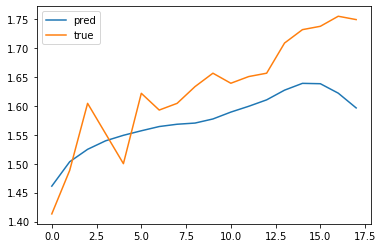

In [25]:
import matplotlib.pyplot as plt
import numpy as np

ind = np.random.choice(128)
print(ind)
plt.plot(output[ind,:,1].detach().cpu().numpy(), label='pred')
# plt.plot(output[ind,:,1].detach().cpu().numpy(), label='pred_5')
# plt.plot(output[ind,:,2].detach().cpu().numpy(), label='pred_9')

plt.plot(batch['outputs'][ind,:,0], label='true')
plt.legend()